<a href="https://colab.research.google.com/github/1900690/kyouyu/blob/main/syakuyaku.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#ドライブマウント
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#AVIファイルをmp4に変換する

In [ ]:
#ファイルコピー
import shutil
shutil.copyfile("/content/drive/MyDrive/TLC00001.AVI", "/content/TLC00001.AVI")

'/content/TLC00001.AVI'

In [ ]:
!pip install opencv-python
!pip install opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#ライブラリのインポート
import cv2

#VideoCaptureオブジェクトを取得
cap = cv2.VideoCapture('/content/TLC00001.AVI')

#動画のプロパティを取得
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

#書き出し設定
fourcc = cv2.VideoWriter_fourcc('m','p','4','v')
writer = cv2.VideoWriter('/content/TLC00001.mp4', fourcc, fps, (width, height))

while True:
    ret, frame = cap.read()
    writer.write(frame)
    if not ret:
        break

writer.release()
cap.release()

In [ ]:
#ファイルコピー
import shutil
shutil.copyfile("/content/TLC00004.mp4", "/content/drive/MyDrive/TLC00004.mp4")

'/content/drive/MyDrive/TLC00004.mp4'

#動画から画像を取り出す

In [ ]:
import cv2
import os

LOAD_FOLDA = '/content/drive/MyDrive/bunkatuyou'

def save_frame_range(video_path,
                     dir_path, ext='jpg'):
  
    basename=video_path[-12:-4]
    cap = cv2.VideoCapture(video_path)
    
    # 総フレーム数
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT));

    #真ん中+1のフレームを取り出すプラスの数値を調整することでフレームをずらせる
    center_frame=total_frames//2+40
    start_frame=0#center_frame
    stop_frame=total_frames
    step_frame=100#center_frame

    if not cap.isOpened():
        return

    os.makedirs(dir_path, exist_ok=True)
    base_path = os.path.join(dir_path, basename)

    digit = len(str(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))))

    for n in range(start_frame, stop_frame, step_frame):
        cap.set(cv2.CAP_PROP_POS_FRAMES, n)
        ret, frame = cap.read()
        if ret:
            cv2.imwrite('{}_{}.{}'.format(base_path, str(n).zfill(digit), ext), frame)
        else:
            return

#スライスフォルダを作成
SAVE_NAME = 'slice'
if not os.path.exists('./' +SAVE_NAME):
    os.mkdir('./' +SAVE_NAME)

LOAD_NAME = os.listdir(LOAD_FOLDA)


for file_name in LOAD_NAME:
  IMAGE_PATH= LOAD_FOLDA +'/'+file_name
  save_frame_range(IMAGE_PATH,
                 '/content/'+SAVE_NAME)
  
image_date=LOAD_FOLDA[-8:]

In [ ]:
#画像をまとめてダウンロード
from google.colab import files
import shutil

shutil.make_archive('slice', format='zip', root_dir='/content/slice')

files.download('slice.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#fastlabelでアノテーション済みの画像から切り取りを行う

問題は複数クラスが複数本数存在するため従来の切り取り方法が使えない
→csvデータと全クラスのカラーデータから

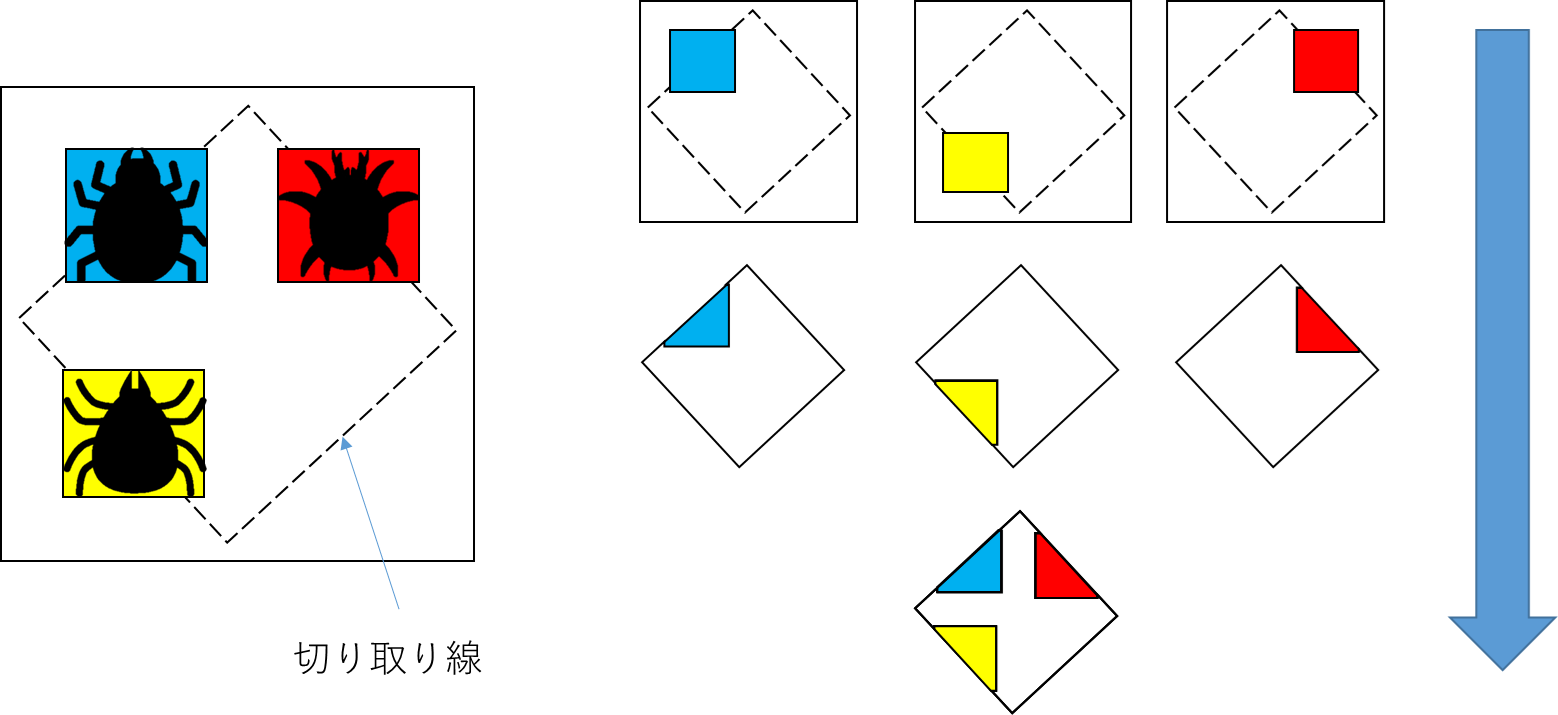

In [ ]:
#@title オリジナル画像をアップロード
#ライブラリをインポート(機能を使えるようにする)
import shutil
import os
import glob


#データを入れるためのフォルダを作成（すでにフォルダがある場合は消去する）
if os.path.exists('/content/originals_test'):
  shutil.rmtree('/content/originals_test')
if not os.path.exists('/content/originals_test'):
    os.makedirs('/content/originals_test')

#カレントディレクトリを移動
%cd -q '/content/originals_test/'

#データをアップロード
from google.colab import files
uploaded = files.upload()

#ファイルをまとめてリネーム
path = '/content/originals_test/'
files = glob.glob(path + '/*')
for f in files:
    os.rename(f, os.path.join(path, 'img_' + os.path.basename(f)))

#元のディレクトリに戻る
%cd -q '/content/'

Saving TLC00004_000.jpg to TLC00004_000.jpg
Saving TLC00004_100.jpg to TLC00004_100.jpg
Saving TLC00004_200.jpg to TLC00004_200.jpg
Saving TLC00004_300.jpg to TLC00004_300.jpg
Saving TLC00004_400.jpg to TLC00004_400.jpg


In [ ]:
#@title データを入れるための大本フォルダを作成
if os.path.exists('/content/instance_segmentations'):
  shutil.rmtree('/content/instance_segmentations')
if not os.path.exists('/content/instance_segmentations'):
    os.makedirs('/content/instance_segmentations')

#フォルダ数カウント用の関数を定義
count_file_number=0

In [ ]:
#@title ダイレクトカラー画像をアップロード(クラスの数だけくりかえす)
#ライブラリをインポート(機能を使えるようにする)
import shutil
import os
import glob

#データを入れるためのフォルダを作成（すでにフォルダがある場合は消去する）
if os.path.exists('/content/instance_segmentations/'+str(count_file_number).zfill(3)):
  shutil.rmtree('/content/instance_segmentations/'+str(count_file_number).zfill(3))
if not os.path.exists('/content/instance_segmentations/'+str(count_file_number).zfill(3)):
  os.makedirs('/content/instance_segmentations/'+str(count_file_number).zfill(3))

#カレントディレクトリを移動
passname='/content/instance_segmentations/'+str(count_file_number).zfill(3)
%cd -q $passname

#データをアップロード
from google.colab import files
uploaded = files.upload()

#ファイルをまとめてリネーム
path = '/content/instance_segmentations/'+str(count_file_number).zfill(3)
files = glob.glob(path + '/*')
for f in files:
    os.rename(f, os.path.join(path, 'img_' + os.path.basename(f)))

#元のディレクトリに戻る
%cd -q '/content/'

#フォルダ数を１増やす
count_file_number=count_file_number+1

Saving TLC00004_000.png to TLC00004_000.png
Saving TLC00004_100.png to TLC00004_100.png
Saving TLC00004_200.png to TLC00004_200.png
Saving TLC00004_300.png to TLC00004_300.png
Saving TLC00004_400.png to TLC00004_400.png


#複数クラス検出

In [ ]:
#@title グーグルドライブに接続

from google.colab import drive
drive.mount('/content/drive')

In [2]:
#@title ultralytics(AIライブラリ)をインストール
%pip -q install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.112 🚀 Python-3.10.11 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 23.3/78.2 GB disk)


In [3]:
#@title 動画で検証

#作業ディレクトリを移動
%cd '/content/drive/MyDrive/flower'

!yolo task=detect \
      mode=predict \
      model=/content/drive/MyDrive/flower/runs/detect/train/weights/best.pt \
      conf=0.3 \
      imgsz=1280\
      show_conf=False \
      save_txt=True \
      device=0\
      source="/content/drive/MyDrive/TLC00004.mp4"

/content/drive/MyDrive/flower
Ultralytics YOLOv8.0.112 🚀 Python-3.10.11 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 268 layers, 68124531 parameters, 0 gradients

video 1/1 (1/525) /content/drive/MyDrive/TLC00004.mp4: 736x1280 59 flowers, 119.8ms
video 1/1 (2/525) /content/drive/MyDrive/TLC00004.mp4: 736x1280 59 flowers, 115.9ms
video 1/1 (3/525) /content/drive/MyDrive/TLC00004.mp4: 736x1280 58 flowers, 116.1ms
video 1/1 (4/525) /content/drive/MyDrive/TLC00004.mp4: 736x1280 58 flowers, 114.7ms
video 1/1 (5/525) /content/drive/MyDrive/TLC00004.mp4: 736x1280 58 flowers, 115.3ms
video 1/1 (6/525) /content/drive/MyDrive/TLC00004.mp4: 736x1280 60 flowers, 116.2ms
video 1/1 (7/525) /content/drive/MyDrive/TLC00004.mp4: 736x1280 59 flowers, 117.0ms
video 1/1 (8/525) /content/drive/MyDrive/TLC00004.mp4: 736x1280 60 flowers, 116.2ms
video 1/1 (9/525) /content/drive/MyDrive/TLC00004.mp4: 736x1280 59 flowers, 115.3ms
video 1/1 (10/525) /content/drive/MyDrive/TLC00004.mp4: 7

In [ ]:
#@title 圧縮してダウンロード
#ライブラリをインポート
import shutil
import os
from google.colab import files

#スイッチ
ファイルをグーグルドライブに保存=False#@param {type:"boolean"}
drive=ファイルをグーグルドライブに保存
ファイルをダウンロードする=True#@param {type:"boolean"}
direct=ファイルをダウンロードする

#圧縮
shutil.make_archive('/content/predict', format='zip', root_dir='/content/drive/MyDrive/pest-object-detection/runs/detect/predict2')
if drive==True:
  #グーグルドライブに接続
  from google.colab import drive
  drive.mount('/content/drive')
  #グーグルドライブにコピー
  shutil.copyfile("/content/datasets.zip","/content/drive/MyDrive/datasets.zip")
  
if direct==True:
  files.download("/content/predict.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#追跡検出

In [ ]:
#@title グーグルドライブに接続

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title ultralytics(AIライブラリ)をインストール
%pip -q install ultralytics
import ultralytics
ultralytics.checks()

In [8]:
#@title 検出
from ultralytics import YOLO

#作業ディレクトリを移動
%cd '/content/drive/MyDrive/flower'

# Load a model
model = YOLO('/content/drive/MyDrive/flower/runs/detect/train/weights/best.pt')  # load a custom model

# Track with the model
results = model.track(source="/content/drive/MyDrive/TLC00004.mp4",show_conf=False,save_txt=True,save=True,stream = False,tracker="bytetrack.yaml") 

/content/drive/MyDrive/flower




    WARNING ⚠️ stream/video/webcam/dir predict source will accumulate results in RAM unless `stream=True` is passed,
    causing potential out-of-memory errors for large sources or long-running streams/videos.

    Usage:
        results = model(source=..., stream=True)  # generator of Results objects
        for r in results:
            boxes = r.boxes  # Boxes object for bbox outputs
            masks = r.masks  # Masks object for segment masks outputs
            probs = r.probs  # Class probabilities for classification outputs

video 1/1 (1/525) /content/drive/MyDrive/TLC00004.mp4: 736x1280 59 flowers, 134.7ms
video 1/1 (2/525) /content/drive/MyDrive/TLC00004.mp4: 736x1280 58 flowers, 126.5ms
video 1/1 (3/525) /content/drive/MyDrive/TLC00004.mp4: 736x1280 58 flowers, 128.1ms
video 1/1 (4/525) /content/drive/MyDrive/TLC00004.mp4: 736x1280 58 flowers, 127.5ms
video 1/1 (5/525) /content/drive/MyDrive/TLC00004.mp4: 736x1280 58 flowers, 127.9ms
video 1/1 (6/525) /content/drive/MyDriv

In [11]:
#@title 保存
#ライブラリをインポート
import shutil
import os
from google.colab import files

#スイッチ
ファイルをグーグルドライブに保存=False#@param {type:"boolean"}
drive=ファイルをグーグルドライブに保存
ファイルをダウンロードする=True#@param {type:"boolean"}
direct=ファイルをダウンロードする

#作業ディレクトリを移動
%cd '/content'

#圧縮
shutil.make_archive('/content/datasets', format='zip', root_dir='/content/drive/MyDrive/flower/runs/detect/track/labels')
if drive==True:
  #グーグルドライブに接続
  from google.colab import drive
  drive.mount('/content/drive')
  #グーグルドライブにコピー
  shutil.copyfile("/content/datasets.zip","/content/drive/MyDrive/datasets.zip")
  
if direct==True:
  files.download("/content/datasets.zip")

/content


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>